 training only. Inference is done in a separate notebook


In [1]:
# Few imports

import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
import time
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Before starting, clear the memory

torch.cuda.empty_cache()

In [3]:
# Define the transformations. To begin with, we shall keep it minimum - only resizing the images and converting them to PyTorch tensors

data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])

In [4]:
# Defining hyperparameters

BATCH_SIZE = 256
learning_rate = 0.001
EPOCHS = 15
numClasses = 43

In [5]:
# Define path of training data

train_data_path = "../GTSRB/Train"
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)

# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

Number of training samples = 31367
Number of validation samples = 7842


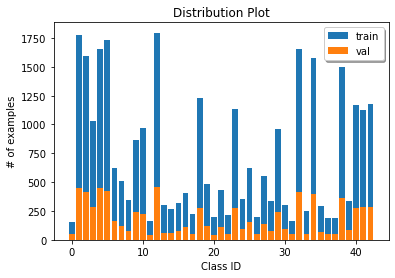

In [6]:
# Plot histogram for training and validation data

train_hist = [0]*numClasses
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1
    
val_hist = [0]*numClasses
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

plt.bar(range(numClasses), train_hist, label="train")
plt.bar(range(numClasses), val_hist, label="val")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.savefig("train_val_split.png", bbox_inches = 'tight', pad_inches=0.5)

In [7]:
# Create data loader for training and validation

train_loader = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)

In [8]:
# Function to count the number of parameters in the model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
# Initialize the model
# The model is defined in the class AlexnetTS in the file class_alexnetTS.py

from class_alexnetTS import AlexnetTS
model = AlexnetTS(numClasses)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,063,891 trainable parameters


In [10]:
# Define optimizer and criterion functions

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [12]:
# If CUDA is available, convert model and loss to cuda variables

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [13]:
# Print model

print(model)

AlexnetTS(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5,

In [14]:
# Print summary of the model for the given dimension of the image

print(summary(model, (3, 112, 112))) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,792
         MaxPool2d-2           [-1, 64, 28, 28]               0
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 192, 28, 28]         110,784
         MaxPool2d-5          [-1, 192, 14, 14]               0
              ReLU-6          [-1, 192, 14, 14]               0
            Conv2d-7          [-1, 384, 14, 14]         663,936
              ReLU-8          [-1, 384, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         884,992
             ReLU-10          [-1, 256, 14, 14]               0
           Conv2d-11          [-1, 256, 14, 14]         590,080
        MaxPool2d-12            [-1, 256, 7, 7]               0
             ReLU-13            [-1, 256, 7, 7]               0
          Dropout-14                [-1

In [15]:
# Print model's state dict

print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("")

Model's state dict:
features.0.weight 	 torch.Size([64, 3, 3, 3])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 3, 3])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.1.weight 	 torch.Size([1000, 12544])
classifier.1.bias 	 torch.Size([1000])
classifier.4.weight 	 torch.Size([256, 1000])
classifier.4.bias 	 torch.Size([256])
classifier.6.weight 	 torch.Size([43, 256])
classifier.6.bias 	 torch.Size([43])



In [16]:
# Print optimizer details

print("Optimizer details:")
print(optimizer)
print("")

Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)



In [17]:
# Function to calculate accuracy

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [18]:
# Function to perform training of the model

def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    
    for (images, labels) in loader:
        images = images.cuda()
        labels = labels.cuda()
        
        # Training pass
        opt.zero_grad()
        
        output, _ = model(images)
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        
        # Calculate accuracy
        acc = calculate_accuracy(output, labels)
        
        # Optimizing weights
        opt.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [19]:
# Function to perform evaluation on the trained model

def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.cuda()
            labels = labels.cuda()
            
            # Run predictions
            output, _ = model(images)
            loss = criterion(output, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [20]:
# Perform training

# List to save training and val loss and accuracies
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
    print("")

Epoch-0: 
Training: Loss = 3.3030, Accuracy = 0.1031, Time = 41.95 seconds
Validation: Loss = 2.3079, Accuracy = 0.3190, Time = 7.75 seconds

Epoch-1: 
Training: Loss = 1.6749, Accuracy = 0.4347, Time = 41.50 seconds
Validation: Loss = 1.2139, Accuracy = 0.5639, Time = 7.73 seconds

Epoch-2: 
Training: Loss = 1.0333, Accuracy = 0.6429, Time = 41.69 seconds
Validation: Loss = 0.6028, Accuracy = 0.7910, Time = 7.64 seconds

Epoch-3: 
Training: Loss = 0.4409, Accuracy = 0.8486, Time = 41.78 seconds
Validation: Loss = 0.2274, Accuracy = 0.9258, Time = 7.70 seconds

Epoch-4: 
Training: Loss = 0.1945, Accuracy = 0.9361, Time = 41.34 seconds
Validation: Loss = 0.0944, Accuracy = 0.9738, Time = 7.91 seconds

Epoch-5: 
Training: Loss = 0.0993, Accuracy = 0.9693, Time = 41.56 seconds
Validation: Loss = 0.0497, Accuracy = 0.9867, Time = 7.89 seconds

Epoch-6: 
Training: Loss = 0.0707, Accuracy = 0.9777, Time = 42.38 seconds
Validation: Loss = 0.0317, Accuracy = 0.9912, Time = 7.97 seconds

Epoch-

In [21]:
# Saving the model

# Create folder to save model
MODEL_FOLDER = "../Model"
if not os.path.isdir(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
PATH_TO_MODEL = MODEL_FOLDER + "/pytorch_classification_alexnetTS.pth"
if os.path.exists(PATH_TO_MODEL):
    os.remove(PATH_TO_MODEL)
torch.save(model.state_dict(), PATH_TO_MODEL)

print("Model saved at %s" %(PATH_TO_MODEL))

Model saved at ../Model/pytorch_classification_alexnetTS.pth


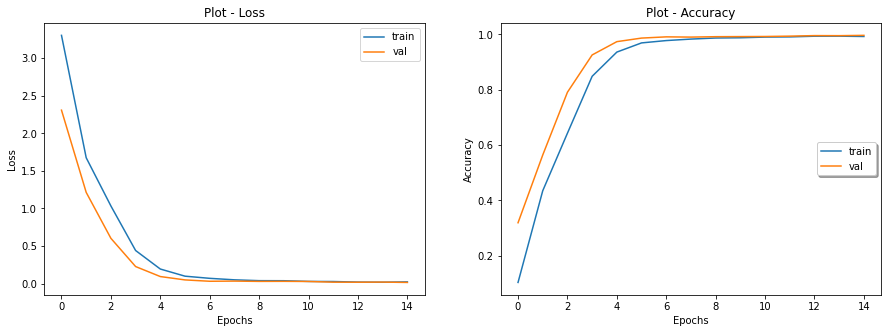

In [22]:
# Plot loss and accuracies for training and validation data

_, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_loss_list, label="train")
axs[0].plot(val_loss_list, label="val")
axs[0].set_title("Plot - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)

# Accuracy plot
axs[1].plot(train_acc_list, label="train")
axs[1].plot(val_acc_list, label="val")
axs[1].set_title("Plot - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right', shadow=True)